In [34]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
import requests
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor, sin, cos, sqrt, atan2, radians, asin
import re
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
import folium
import geopandas as gpd
from itertools import combinations
import osmium
import branca

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

base = 'Data'
police_complaints_dataset="police_complaints"
#base = '/home/bsilva/Desktop'
#base = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3/'

### Load datasets

In [3]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base, year_start, year_end):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(year_start) + ".csv", sep=";")
    
    for year in range(year_start+1, year_end+1):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base+"/noise_data/csv_format", 2016, 2019)


#secalhar eliminar...
def saving_dfs_as_binary_files(base, file_list, raw_name):
    
    df = pd.read_csv(base+'/'+file_list[0]+ ".csv", sep=";")
    
    for file in file_list[1:]:
        _df_file = pd.read_csv(base+'/'+file+ ".csv", sep=";")
        df = pd.concat([df, _df_file])
    
    pickle.dump(df, open(base+'/'+raw_name, "wb"))
        


In [4]:

# Opening data
def get_sensors_data():
    df = pickle.load(open(base+'/'+"noise_data/csv_format/df_raw", "rb" ))

    for col in ['C1', 'C2', 'C3', 'C4', 'C5']:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"], format='%d-%m-%Y')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)


    return df[['date', 'year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5']]
    
df = get_sensors_data()
df

,date,year,month,day,hour,C1,C2,C3,C4,C5
0,2016-06-01,2016,6,1,0,61.1,58.8,63.7,60.4,60.2
1,2016-06-01,2016,6,1,1,57.2,56.1,60.4,57.7,58.4
2,2016-06-01,2016,6,1,2,52.5,53.4,52.9,56.7,56.5
3,2016-06-01,2016,6,1,3,50.6,46.6,45.7,47.9,55.6
4,2016-06-01,2016,6,1,4,47.4,46.2,45.1,45.8,56.8
...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31,2019,12,31,19,62.2,59.8,60.3,NaN,NaN
8756,2019-12-31,2019,12,31,20,59.4,59.7,55.9,NaN,NaN
8757,2019-12-31,2019,12,31,21,59.2,61.0,56.0,NaN,NaN
8758,2019-12-31,2019,12,31,22,57.0,60.2,56.0,NaN,NaN


Load the district zones in order to check which district code San Salvario belongs to.

In [5]:
gdf_zones = gpd.read_file(base+"/circoscrizioni_geo.zip")
gdf_zones.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_zones.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_zones

,NCIRCO,DENOM,geometry
0,1,Centro - Crocetta,"POLYGON ((7.65385 45.04991, 7.65489 45.05139, ..."
1,2,Santa Rita - Mirafiori,"POLYGON ((7.57787 45.04181, 7.58035 45.04427, ..."
2,3,San Paolo - Cenisia - Pozzo Strada - Cit Turin...,"POLYGON ((7.60367 45.07135, 7.60431 45.07222, ..."
3,5,Borgo Vittoria - Madonna di Campagna - Lucento...,"POLYGON ((7.61182 45.10712, 7.61264 45.10741, ..."
4,6,Barriera di Milano - Regio Parco - Barca - Ber...,"MULTIPOLYGON (((7.74046 45.11945, 7.74152 45.1..."
5,7,"Aurora, Vanchiglia - Sassi - Madonna del Pilone","POLYGON ((7.67136 45.08077, 7.67206 45.08175, ..."
6,8,San Salvario - Cavoretto - Borgo Po - Nizza Mi...,"POLYGON ((7.63602 45.02339, 7.63622 45.02355, ..."
7,4,San Donato - Campidoglio - Parella,"POLYGON ((7.60571 45.07408, 7.60575 45.07413, ..."


San Salvario belongs to the district code 8

Load complaints dataset.  
Not all of the complaints are relevant to this challenge, such as complaints regarding abandoned vehicles, vandalism or aggressions. Therefore we are only interested in complaints regarding loud noises (Rumori molesti).  
At some times, we may also be interested in complaints located in district 8 (San Salvario), which is where all sensors are.

In [118]:
def append_to_df(df, path, xlsx=False, sep=','):
    df=pd.concat([
        df, 
        pd.read_excel(path, engine='openpyxl') if xlsx else pd.read_csv(path, sep=sep, encoding='latin-1')
    ])
    
    return df
 
def read_complaints(only_salvario):
    df_complaints=pd.read_csv('./Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', sep=',')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/Contact_Gennaio_Giugno_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx', xlsx=True)
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', sep=';')
 
    df_complaints = df_complaints.loc[df_complaints['Sottocategoria Criminologica'] == 'Rumori molesti']
    if only_salvario:
        df_complaints = df_complaints.loc[df_complaints['Circoscrizione'] == 8.0]
    df_complaints['Localita'] = df_complaints['Localita'].apply(lambda x : x.strip())
    df_complaints['Data'] = pd.to_datetime(df_complaints['Data'])
    return df_complaints
 
df_complaints=read_complaints(True)
df_complaints.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
557,Convivenza Civile,Rumori molesti,8.0,MARCONI/GUGLIELMO (CORSO),NaN,2016-02-24,NaN
562,Convivenza Civile,Rumori molesti,8.0,PETITTI/ILARIONE (VIA),NaN,2016-10-03,NaN
578,Convivenza Civile,Rumori molesti,8.0,GOITO/(VIA),NaN,2016-04-15,NaN
583,Convivenza Civile,Rumori molesti,8.0,GALLIARI/BERNARDINO (VIA),NaN,2016-04-22,NaN
592,Convivenza Civile,Rumori molesti,8.0,CELLINI/BENVENUTO (VIA),NaN,2016-05-13,NaN


Load sensor locations dataset

In [11]:
def convert_coord_to_number(coord_str):
    return float(coord_str.replace(',', '.'))

sensor_zones_df = pd.read_csv(base+"/noise_sensor_list.csv", sep=";")[['code', 'address', 'Lat', 'Long']]

sensor_zones_df['Lat'] = sensor_zones_df['Lat'].apply(lambda x : convert_coord_to_number(x))
sensor_zones_df['Long'] = sensor_zones_df['Long'].apply(lambda x : convert_coord_to_number(x))

sensor_zones_df

,code,address,Lat,Long
0,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986
1,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555
2,s_03,Largo Saluzzo Torino,45.058518,7.678854
3,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348
4,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590


### Businesses and Noise Levels Analysis

Read file containing the businesses location and type. Remove businesses whose Merchandise Type is unknown (Nessuna)

In [141]:
gdf_businesses = gpd.read_file(base+"/businesses.csv", sep=';')
gdf_businesses.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_businesses.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_businesses = gdf_businesses[gdf_businesses['Merchandise Type'] != 'Nessuna']
gdf_businesses.head(10)

,WKT,ADDRESS,OPEN YEAR,OPEN MONTH,TYPE,Description,Merchandise Type,geometry
0,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1977,1,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68288 45.05840)
1,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1985,6,ALIMENTARI,PICCOLE STRUTTURE,Panificio,POINT (7.68288 45.05840)
8,POINT (1396009.149 4990467.107),VIA CLAUDIO LUIGI BERTHOLLET 2/G,2017,3,MISTA,PICCOLE STRUTTURE,Gastronomia,POINT (7.67887 45.05985)
9,POINT (1396357.532 4990581.082),CORSO VITTORIO EMANUELE II 25/G,2017,4,EXTRALIMENTARI,PICCOLE STRUTTURE,Mobili,POINT (7.68327 45.06092)
11,POINT (1396009.149 4990467.107),VIA CLAUDIO LUIGI BERTHOLLET 2/G,2017,3,MISTA,PICCOLE STRUTTURE,Extralimentari,POINT (7.67887 45.05985)
12,POINT (1396357.532 4990581.082),CORSO VITTORIO EMANUELE II 25/G,2007,2,EXTRALIMENTARI,PICCOLE STRUTTURE,Mobili,POINT (7.68327 45.06092)
15,POINT (1396368.751 4990575.145),CORSO VITTORIO EMANUELE II 25,1989,7,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68342 45.06087)
16,POINT (1396022.809 4990459.897),VIA CLAUDIO LUIGI BERTHOLLET 4/C,2018,1,MISTA,PICCOLE STRUTTURE,Mista,POINT (7.67905 45.05978)
17,POINT (1396022.809 4990459.897),VIA CLAUDIO LUIGI BERTHOLLET 4/C,2016,5,ALIMENTARI,PICCOLE STRUTTURE,Alimentari,POINT (7.67905 45.05978)
18,POINT (1396342.72 4990588.919),CORSO VITTORIO EMANUELE II 27/C,1986,11,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68309 45.06099)


In [143]:
unique_adresses = gdf_businesses.ADDRESS.unique()

Group the number of complains by local

In [144]:
df_complains_by_local = df_complaints.groupby("Localita").size().reset_index(name='complaint_count')
df_complains_by_local.head()

,Localita,complaint_count
0,AMADEO/G. ANTONIO (VIA),1
1,ARGENTERO/GIOVANNI (VIA),1
2,ASTI/(VIA),1
3,BARETTI/GIUSEPPE (VIA),1
4,BELFIORE/(VIA),6


In [149]:
#helper function to assign roads into more specific addresses. Does not always work...
def search_address(address):
    key_words = re.split(r'[\s+\(\)/,;]+', address)
    key_words = set(key_words)
    if "VIA" in key_words:
        key_words.remove("VIA")
    if "CORSO" in key_words:
        key_words.remove("CORSO")
    if "" in key_words:
        key_words.remove("")
    ratio = 0
    matched_addr=""
    for adr in unique_adresses:
        adr_words = re.split(r'[\s+\(\)/,;]+', adr)
        adr_words = set(adr_words)
        r = 0
        for word in key_words:
            if word in adr_words:
                r +=1
        if r > ratio:
            matched_addr = adr
    return matched_addr

#search_address("BARETTI/GIUSEPPE (VIA)") #Test

In [150]:
def add_coords(local):
    address = search_address(local)
    if address != "":
        #get coordinate of address
        c = gdf_businesses.loc[gdf_businesses['ADDRESS'] == address, 'geometry'].iloc[0]
        return (c.y, c.x)
    
df_complains_by_local['coords'] = df_complains_by_local.apply(lambda x: add_coords(x['Localita']), axis=1)
df_complains_by_local.head()

,Localita,complaint_count,coords
0,AMADEO/G. ANTONIO (VIA),1,None
1,ARGENTERO/GIOVANNI (VIA),1,None
2,ASTI/(VIA),1,None
3,BARETTI/GIUSEPPE (VIA),1,"(45.0575352701371, 7.681219625833094)"
4,BELFIORE/(VIA),6,"(45.05910054446746, 7.680404960837597)"


For this district, between 2016 and 2019, there was a minimum of 1 complain and a maximum of 6 complains

We will now visualize the sensor's positions in a map, as well as the sinalize the locations of some of the complains in order to get more conclusions. This type of analysis can reveal useful information such as why certain zones have more complains than others. It is also useful to understand how the sensors are spatially situaded: are they too close to each other or very far?  
We did not added business data on the map because OpenSteetMap already has a few of this information visible on the map, but also because it would be harder to read the map.

Black Markers represent the censors. Click on them to see their name and their address.  
Markers with a "megaphone" icon represent an estimate location of complaints registered in that road between 2016 and 2019. The color indicates the number of complaints registered. Click on a marker to see their number of complaints.

In [17]:
#assign colors to the number of complains
dic_category_colors = {
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red',
    6: 'darkred'
}

In [165]:
m=folium.Map(location=[45.05801, 7.68204], zoom_start=16) #initialize map at San Salvario

def add_marker(title, descr, lat, long, group, color, icon):
    folium.Marker(location=[float(lat), float(long)], popup="<html>"+title+"<br/>"+descr+"</html>",
                 icon=folium.Icon(color=color, icon=icon)).add_to(group)
    
def add_circle_mark(title, descr, n, coords, group):
    if coords == None:
        return
    folium.Marker(location=[coords[0], coords[1]], popup="<html>"+title+"<br/>"+descr+"</html>",\
                icon=folium.Icon(color=dic_category_colors[n], icon='volume-up')).add_to(group)
    
comp_group = folium.FeatureGroup('Markers - complains')
comp_group.add_to(m)
bus_group = folium.FeatureGroup('Markers - businesses')
bus_group.add_to(m)
sens_group = folium.FeatureGroup('Markers - sensors')
sens_group.add_to(m)

    
#gdf_businesses.apply(lambda l: add_marker("type: "+l['Merchandise Type'], "", l.geometry.y, l.geometry.x, 
#                                          bus_group, 'grey','usd'),axis=1)
#add sensor data
sensor_zones_df.apply(lambda l: add_marker("sensor code: "+str(l['code']), l['address'], l.Lat, l.Long, 
                                           sens_group, 'black', 'hdd'),axis=1)

                                 
#add complaint data
df_complains_by_local.apply(lambda l: add_circle_mark("Address: "+str(l['Localita']), "Nº complains: "+
                           str(l['complaint_count']), l['complaint_count'], l.coords, comp_group),axis=1)

#draw the districts zones on the map
#adapted from: https://geopandas.readthedocs.io/en/latest/gallery/polygon_plotting_with_folium.html
for _, r in gdf_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, name=r['DENOM'],
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup("zone code: "+str(r['NCIRCO'])+"\ndistrict: "+r['DENOM']).add_to(geo_j)
    geo_j.add_to(m)

folium.LayerControl().add_to(m)
#add legend
legend_html = '''
{% macro html(this, kwargs) %}
<div style="
    position: fixed; 
    bottom: 180px;
    left: 20px;
    width: 120px;
    height: 80px;
    z-index:9999;
    font-size:14px;
    ">
    <p><b>Noise complaints marker colors:</b></p>
    <p><a style="color:'''+str(dic_category_colors[1])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(1)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[2])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(2)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[3])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(3)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[4])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(4)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[5])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(5)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[6])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(6)+'''</p>
</div>
<div style="
    position: fixed; 
    bottom: 8px;
    left: 20px;
    width: 112px;
    height: 280px; 
    z-index:9998;
    font-size:14px;
    background-color: #ffffff;
    opacity: 0.7;
    ">
</div>
{% endmacro %}
'''
legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
m.get_root().add_child(legend)

m

<ipython-input-165-3919c10f678f>:11: UserWarning: color argument of Icon should be one of: {'pink', 'green', 'lightred', 'darkpurple', 'orange', 'blue', 'darkblue', 'red', 'lightgray', 'cadetblue', 'white', 'beige', 'black', 'darkgreen', 'lightgreen', 'purple', 'gray', 'darkred', 'lightblue'}.
  icon=folium.Icon(color=dic_category_colors[n], icon='volume-up')).add_to(group)


Regarding sensors, we can see that there are 2 pairs of sensors that are very close: 
 - Sensor s_02 (C2) and s_05 (C4), meaning that they can intercept similar levels of noise - coffes and restaurants are near these sensors
 - Sensor s_01 (C1) and s_03 (C3), although not as close as the previous pair. Restaurants are near these sensors
 - Sensor s_06 (C5) is separated from the remaining. Appears to be on larger road, meaning that more noise may be detected  
 
This is important and we will take the sensor's position into consideration for our analysis.

We intended to analyze the locals where complaints are registered and analyze which businesses appear near that place, however the data containing businesses presents a full address, but complaints only a road. We could not find road coordinates, so we tried to add markers on the map with complaints placed on top of business in the same road as the complain, however, the markers are only an estimate, as the complain may have happened in another place in the road 

It is still possible to see that in all roads where there is a record of complaints, there are establishments such as bars, restaurants, hotels, and bars which may be responsible to generate higher noises. However we cannot draw a strong enough conclusion as we don't have a specific location of the complaint

In [22]:
gpd_census = gpd.read_file(base+"/census_data/sezioni_censimento_geo_CAP.shp")
gpd_census

,SEZCENS,NCIRCO,DENCIM,LOCALITA,DISTRASS,PARROCCH,TIPOSEZ,ASL,ZONASTAT,NRESID,NFAMIGL,NMASCHI,NFEMM,NSTRAN,AN_0_14,AN_15_64,OLT_65_A,SUPERF,geometry
0,326.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,181.0,94.0,95.0,86.0,42.0,23.0,121.0,37.0,5593.24,"POLYGON ((1396082.920 4990558.645, 1396116.595..."
1,328.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,252.0,144.0,123.0,129.0,110.0,29.0,167.0,56.0,8403.30,"POLYGON ((1396230.062 4990481.191, 1396261.287..."
2,336.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,229.0,126.0,112.0,117.0,26.0,26.0,149.0,54.0,9976.84,"POLYGON ((1396319.969 4990427.448, 1396404.856..."
3,338.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,294.0,160.0,141.0,153.0,27.0,45.0,192.0,57.0,15116.92,"POLYGON ((1396509.732 4990327.177, 1396638.065..."
4,343.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,253.0,150.0,121.0,132.0,72.0,29.0,168.0,56.0,6922.80,"POLYGON ((1396272.570 4990334.580, 1396356.838..."
5,346.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,172.0,86.0,90.0,82.0,21.0,18.0,123.0,31.0,4052.06,"POLYGON ((1396110.590 4990337.667, 1396159.829..."
6,356.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,339.0,196.0,163.0,176.0,70.0,31.0,229.0,79.0,9174.29,"POLYGON ((1396289.940 4990160.821, 1396390.936..."
7,322.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,113.0,65.0,55.0,58.0,15.0,15.0,77.0,21.0,9446.12,"POLYGON ((1396389.050 4990563.934, 1396399.090..."
8,323.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,84.0,50.0,43.0,41.0,8.0,10.0,53.0,21.0,11706.68,"POLYGON ((1396486.289 4990539.884, 1396593.428..."
9,324.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,177.0,107.0,82.0,95.0,15.0,13.0,91.0,73.0,14107.72,"POLYGON ((1396593.428 4990483.221, 1396714.465..."


<AxesSubplot:>

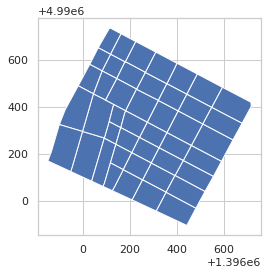

In [23]:
gpd_census.plot()

We have observed that complains occur mostly during the day, meaning that ....

### Noise...

In [81]:
base_noise = './Data/noise_data/csv_format'

df_complaints=read_complaints(True)

def saving_dfs_as_binary_files(base_noise):
    
    df = pd.read_csv(base_noise+'/'+"san_salvario_" + str(2016) + ".csv", sep=";")
    
    for year in range(2017, 2020):
        df_year = pd.read_csv(base_noise+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, df_year])
    
    pickle.dump(df, open(base_noise+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base_noise)
 
 
 
 
 
sensors=["C1", "C2", "C3", "C4", "C5"]
# Opening data
def get_sensors_data(sensors):
    df = pickle.load(open(base_noise+'/'+"df_raw", "rb" ))
 
    for col in sensors:
        df[col] = df[col].str.replace(',', '.').astype(float)
 
    df['date'] = pd.to_datetime(df["Data"] + df['Ora'] , format='%d-%m-%Y%H:00')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)
    
    df = df.set_index('date')
    
    df['C1_temp'] = pow(10, df['C1']/10)
    df['C2_temp'] = pow(10, df['C2']/10)
    df['C3_temp'] = pow(10, df['C3']/10)
    df['C4_temp'] = pow(10, df['C4']/10)
    df['C5_temp'] = pow(10, df['C5']/10)
    
    # e se tiver valores nulos??
    df['C_avg'] = df[['C1_temp', 'C2_temp', 'C3_temp', 'C4_temp', 'C5_temp']].sum(axis = 1).div(5)
    df['C_avg'] = 10*np.log10(df['C_avg'])
    
    #return df
    return df[['year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5', 'C_avg']]
    
df = get_sensors_data(sensors)
df
 
 
 
 
 
def outlier_detection_using_z_score(df, t=2):
    # t - threshold - number of standard deviation
    mean = np.mean(df.iloc[:, 0])
    std = np.std(df.iloc[:, 0])
    
    # não fazemos abs((i-mean)/std) porque só nos interessa os que estão acima da média
    df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
    df['is_outlier'] = [True if x>t else False for x in df.z_score.values ]
    
    df['out'] = df['C1'] * df['is_outlier']
    df['out'] = [None if x==0 else x for x in df.out.values]
 
    df = df.reset_index()
    
    return df
    
    
df_out = outlier_detection_using_z_score(df[['C1']], t=1)
 
 
df_out_max_per_day=df_out.groupby(pd.Grouper(key="date", freq = 'D')).agg({'C1': 'max'})
 
 
 
 
df_complaints_day=df_complaints.groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01')).size().reset_index(name='counts').sort_values("Data")

 
 
df_outlier_day = (df_out.set_index('date')
               .groupby([pd.Grouper(freq = 'D'),'is_outlier'])
               .size()
               .unstack(fill_value=0))
 
    
df_max_peaks_day=pd.merge(df_out_max_per_day, df_outlier_day, left_on="date", right_on="date")[[True, "C1"]].rename(columns={True: "noise_peaks", 'C1':'max_day_peak'})
 
df_max_peaks_day
 
 
 
 
# Merge dfs
df_merged=pd.merge(df_complaints_day, df_max_peaks_day, left_on=["Data"], right_on=["date"], how='inner')
 
df_comp_peaks_day=df_merged[['Data', 'counts', "noise_peaks", "max_day_peak"]].rename(columns={'counts':'complaints'})
 
df_comp_peaks_day

/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-81-8bfa2cd9a633>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
<ipython-input-81-8bfa2cd9a633>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_outlier'] = [True if x>t else False for x in df.z_score.values ]
<ipython-input-81-8bfa2cd9a

,Data,complaints,noise_peaks,max_day_peak
0,2016-06-01,0,3,69.1
1,2016-06-02,0,3,70.8
2,2016-06-03,0,4,68.4
3,2016-06-04,0,8,71.4
4,2016-06-05,0,5,69.9
...,...,...,...,...
1282,2019-12-05,0,2,67.9
1283,2019-12-06,0,2,66.2
1284,2019-12-07,0,3,70.6
1285,2019-12-08,0,5,69.1


In [45]:
wifi_df = pd.read_csv(base+'/'+'WIFI Count.csv')
wifi_df['Time'] = pd.to_datetime(wifi_df['Time'])

wifi_df['date'] = [d.date() for d in wifi_df['Time']]
wifi_df['time'] = [d.time() for d in wifi_df['Time']]

wifi_df['date'] = pd.to_datetime(wifi_df['date'])

del wifi_df['Time']

wifi_df.head()

,No. of Visitors,date,time
0,47,2018-10-24,17:00:00
1,155,2018-10-24,18:00:00
2,181,2018-10-24,19:00:00
3,211,2018-10-24,20:00:00
4,239,2018-10-24,21:00:00


In [76]:
wifi_peaks_complains_df = pd.merge(df_comp_peaks_day, wifi_df, left_on=["Data"], right_on=["date"], how='inner')
del wifi_peaks_complains_df['date']
wifi_peaks_complains_df

,Data,complaints,noise_peaks,max_day_peak,No. of Visitors,time
0,2018-10-24,0,1,66.0,47,17:00:00
1,2018-10-24,0,1,66.0,155,18:00:00
2,2018-10-24,0,1,66.0,181,19:00:00
3,2018-10-24,0,1,66.0,211,20:00:00
4,2018-10-24,0,1,66.0,239,21:00:00
...,...,...,...,...,...,...
1634,2018-12-31,0,2,67.8,158,19:00:00
1635,2018-12-31,0,2,67.8,171,20:00:00
1636,2018-12-31,0,2,67.8,151,21:00:00
1637,2018-12-31,0,2,67.8,125,22:00:00


Data for the number of connected people in the hotspot starts at 2018-10-24 and ends at 2018-12-31

In [66]:
def correlation_matrix (df):
    cor = df.corr()
    
    fig,ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cor, annot=True)

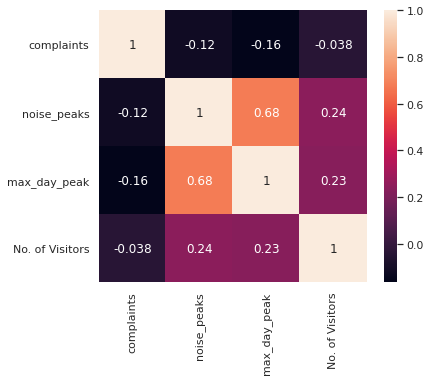

In [67]:
correlation_matrix(wifi_peaks_complains_df)

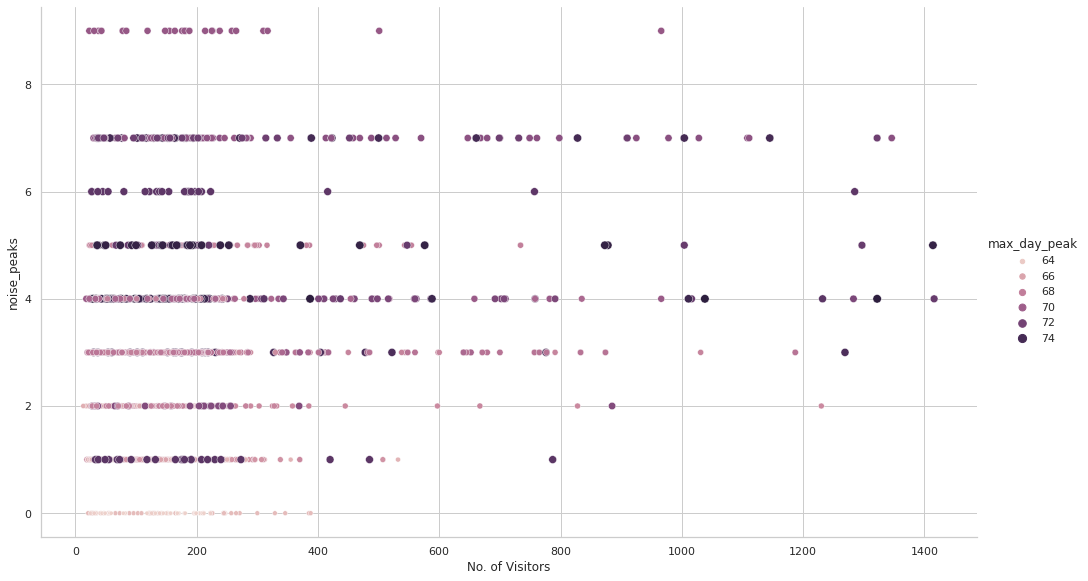

In [75]:
sns.relplot(x="No. of Visitors", y="noise_peaks", hue="max_day_peak", size="max_day_peak", data=wifi_peaks_complains_df, height=8, aspect=1.7);

There seems to be a small correlation between the number of visitors and the noise peaks. However, there are also instances in which less visitorts generate higher peaks of noise

Let us analyze only the complaints now. Because we have data for all districts, we will recreate the dataframe

In [90]:
df_complaints = read_complaints(False)
df_complaints_day=df_complaints.groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01'))\
    .size().reset_index(name='counts').sort_values("Data").rename(columns={'counts':'complaints'})
df_complaints_day['Data'] = pd.to_datetime(df_complaints_day['Data'])
wifi_complains_df = pd.merge(df_complaints_day, wifi_df, left_on=["Data"], right_on=["date"], how='inner')
del wifi_complains_df['date']

wifi_complains_df

,Data,complaints,No. of Visitors,time
0,2018-10-24,0,47,17:00:00
1,2018-10-24,0,155,18:00:00
2,2018-10-24,0,181,19:00:00
3,2018-10-24,0,211,20:00:00
4,2018-10-24,0,239,21:00:00
...,...,...,...,...
1634,2018-12-31,0,158,19:00:00
1635,2018-12-31,0,171,20:00:00
1636,2018-12-31,0,151,21:00:00
1637,2018-12-31,0,125,22:00:00


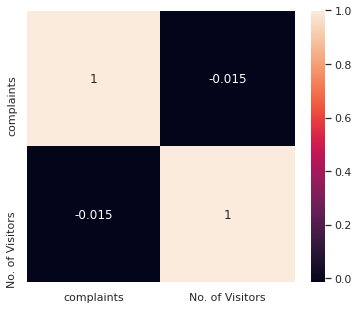

In [97]:
correlation_matrix(wifi_complains_df)

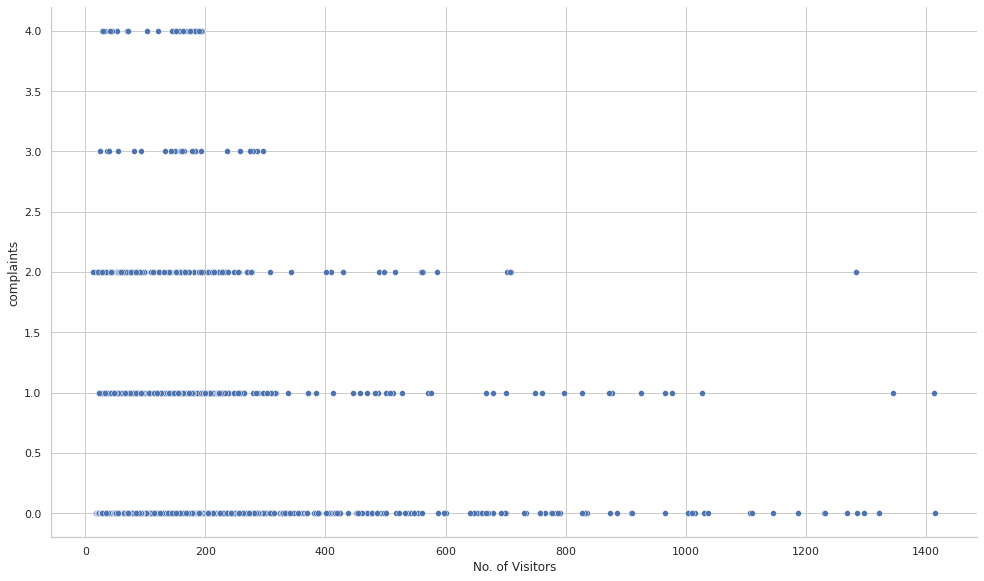

In [94]:
sns.relplot(x="No. of Visitors", y="complaints", data=wifi_complains_df, height=8, aspect=1.7);

### SIM Data VS Noise peaks / Complaints

In [96]:
def read_sim_data():
    df_sim=pd.read_csv('./Data/sim_count/SIM_count_04_100618.csv', sep=';')
    df_sim=append_to_df(df_sim, './Data/sim_count/SIM_count_09_151017.csv', sep=';')
    df_sim=append_to_df(df_sim, './Data/sim_count/SIM_count_15_210118.csv', sep=';')
    df_sim=append_to_df(df_sim, './Data/sim_count/SIM_count_18_241217.csv', sep=';')
    df_sim=append_to_df(df_sim, './Data/sim_count/SIM_count_19_250318.csv', sep=';')
    return df_sim

df_sim = read_sim_data()
df_sim

,cluster,data_da,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi)
0,Presenze,2018-06-10T21:00:00Z,2018-06-10T22:00:00Z,3278,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
1,Presenze,2018-06-10T20:00:00Z,2018-06-10T21:00:00Z,3324,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
2,Presenze,2018-06-10T19:00:00Z,2018-06-10T20:00:00Z,3318,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3,Presenze,2018-06-10T18:00:00Z,2018-06-10T19:00:00Z,3187,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
4,Presenze,2018-06-10T17:00:00Z,2018-06-10T18:00:00Z,2980,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
...,...,...,...,...,...,...,...
3001,Visitatori Stranieri,2018-03-19T03:00:00Z,2018-03-19T04:00:00Z,159,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3002,Visitatori Stranieri,2018-03-19T02:00:00Z,2018-03-19T03:00:00Z,159,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3003,Visitatori Stranieri,2018-03-19T01:00:00Z,2018-03-19T02:00:00Z,165,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3004,Visitatori Stranieri,2018-03-19T00:00:00Z,2018-03-19T01:00:00Z,174,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600


In [98]:
df_sim.data_da.unique()

array(['2018-06-10T21:00:00Z', '2018-06-10T20:00:00Z',
       '2018-06-10T19:00:00Z', '2018-06-10T18:00:00Z',
       '2018-06-10T17:00:00Z', '2018-06-10T16:00:00Z',
       '2018-06-10T15:00:00Z', '2018-06-10T14:00:00Z',
       '2018-06-10T13:00:00Z', '2018-06-10T12:00:00Z',
       '2018-06-10T11:00:00Z', '2018-06-10T10:00:00Z',
       '2018-06-10T09:00:00Z', '2018-06-10T08:00:00Z',
       '2018-06-10T07:00:00Z', '2018-06-10T06:00:00Z',
       '2018-06-10T05:00:00Z', '2018-06-10T04:00:00Z',
       '2018-06-10T03:00:00Z', '2018-06-10T02:00:00Z',
       '2018-06-10T01:00:00Z', '2018-06-10T00:00:00Z',
       '2018-06-09T23:00:00Z', '2018-06-09T22:00:00Z',
       '2018-06-09T21:00:00Z', '2018-06-09T20:00:00Z',
       '2018-06-09T19:00:00Z', '2018-06-09T18:00:00Z',
       '2018-06-09T17:00:00Z', '2018-06-09T16:00:00Z',
       '2018-06-09T15:00:00Z', '2018-06-09T14:00:00Z',
       '2018-06-09T13:00:00Z', '2018-06-09T12:00:00Z',
       '2018-06-09T11:00:00Z', '2018-06-09T10:00:00Z',
       '20

In [ ]:
sim_complains_df = pd.merge(df_complaints_day, df_sim, left_on=["Data"], right_on=["date"], how='inner')
del wifi_complains_df['date']